# Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import time
from openTSNE import TSNE
import os

current_path = os.getcwd()

# Exploratory Data Analysis (EDA)

In [3]:
data_path = os.path.join(current_path, "data", "original", "phase2", "train.csv")
df = pd.read_csv(data_path)
df['label'] = df['label'].apply(str.lower)

features = df.drop(['label'], axis=1)
target = df['label']

## Data Description

In [4]:
"""
Id: Unique identifier for each row in the test set.
flow_time: Duration of network flow.
header_size: Size of the packet headers.
packet_duration: Duration of individual packets.
overall_rate: Overall data transfer rate.
src_rate: Data transfer rate from the source.
dst_rate: Data transfer rate towards the destination.
fin_packets: Number of packets flagged as finished (FIN).
urg_packets: Number of urgent packets (URG).
rst_packets: Number of reset packets (RST).
max_value: Maximum value observed in packet data.
syn_flags: Number of SYN (synchronize) flags detected.
rst_flags: Number of RST (reset) flags detected.
psh_flags: Number of PSH (push) flags detected.
ack_flags: Number of ACK (acknowledge) flags detected.
protocol_http: Indicates HTTP protocol usage.
protocol_https: Indicates HTTPS protocol usage.
protocol_tcp: Indicates TCP protocol usage.
protocol_udp: Indicates UDP protocol usage.
protocol_icmp: Indicates ICMP protocol usage.
label (only in train.csv): Type of cyber-attack to be predicted (e.g., DDoS, DoS, benign).
"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938583 entries, 0 to 938582
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   flow_time         938583 non-null  float64
 1   header_size       938583 non-null  float64
 2   packet_duration   938583 non-null  float64
 3   overall_rate      938583 non-null  float64
 4   src_rate          938583 non-null  float64
 5   dst_rate          938583 non-null  float64
 6   fin_packets       938583 non-null  float64
 7   urg_packets       938583 non-null  float64
 8   rst_packets       938583 non-null  float64
 9   max_value         938583 non-null  float64
 10  value_covariance  938583 non-null  float64
 11  fin_flags         938583 non-null  int64  
 12  syn_flags         938583 non-null  int64  
 13  rst_flags         938583 non-null  int64  
 14  psh_flags         938583 non-null  int64  
 15  ack_flags         938583 non-null  int64  
 16  protocol_http     93

In [5]:
df.describe().round(1)

,flow_time,header_size,packet_duration,overall_rate,src_rate,dst_rate,fin_packets,urg_packets,rst_packets,max_value,...,fin_flags,syn_flags,rst_flags,psh_flags,ack_flags,protocol_http,protocol_https,protocol_tcp,protocol_udp,protocol_icmp
count,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,...,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0
mean,13.4,101813.4,82.7,9163.5,9163.5,0.0,0.1,5.9,37.1,177.2,...,0.1,0.2,0.1,0.1,0.1,0.0,0.1,0.6,0.2,0.2
std,5898.1,1801376.9,167.0,100180.6,100180.6,0.0,0.3,70.7,324.6,515.4,...,0.3,0.4,0.3,0.3,0.3,0.2,0.2,0.5,0.4,0.4
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,54.0,64.0,2.1,2.1,0.0,0.0,0.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,54.0,64.0,15.7,15.7,0.0,0.0,0.0,0.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,0.1,364.0,64.0,117.8,117.8,0.0,0.0,0.0,0.0,55.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,4930147.3,331117370.0,6525.7,7340032.0,7340032.0,0.8,19.5,4136.7,9331.5,30329.2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Classes Distribution

In [6]:
def describe_column(target_col:pd.Series) -> pd.DataFrame:
    overview = pd.DataFrame(target_col.value_counts()).reset_index()
    overview['percentage'] = overview['count'] / overview['count'].sum() * 100
    overview['percentage_str'] = overview['percentage'].apply(lambda x: f"{x:.2f}%")

    return overview


# how many classes do we have?
total_samples = len(df)
print(f"{len(target.unique())} unique labels")

# are the classes unbalanced?

quick_overview = describe_column(target)
quick_overview

6 unique labels


,label,count,percentage,percentage_str
0,ddos,687027,73.198321,73.20%
1,dos,163428,17.412205,17.41%
2,mirai,53395,5.688895,5.69%
3,benigntraffic,21987,2.342574,2.34%
4,recon,6433,0.685395,0.69%
5,mitm,6313,0.672610,0.67%


<BarContainer object of 6 artists>

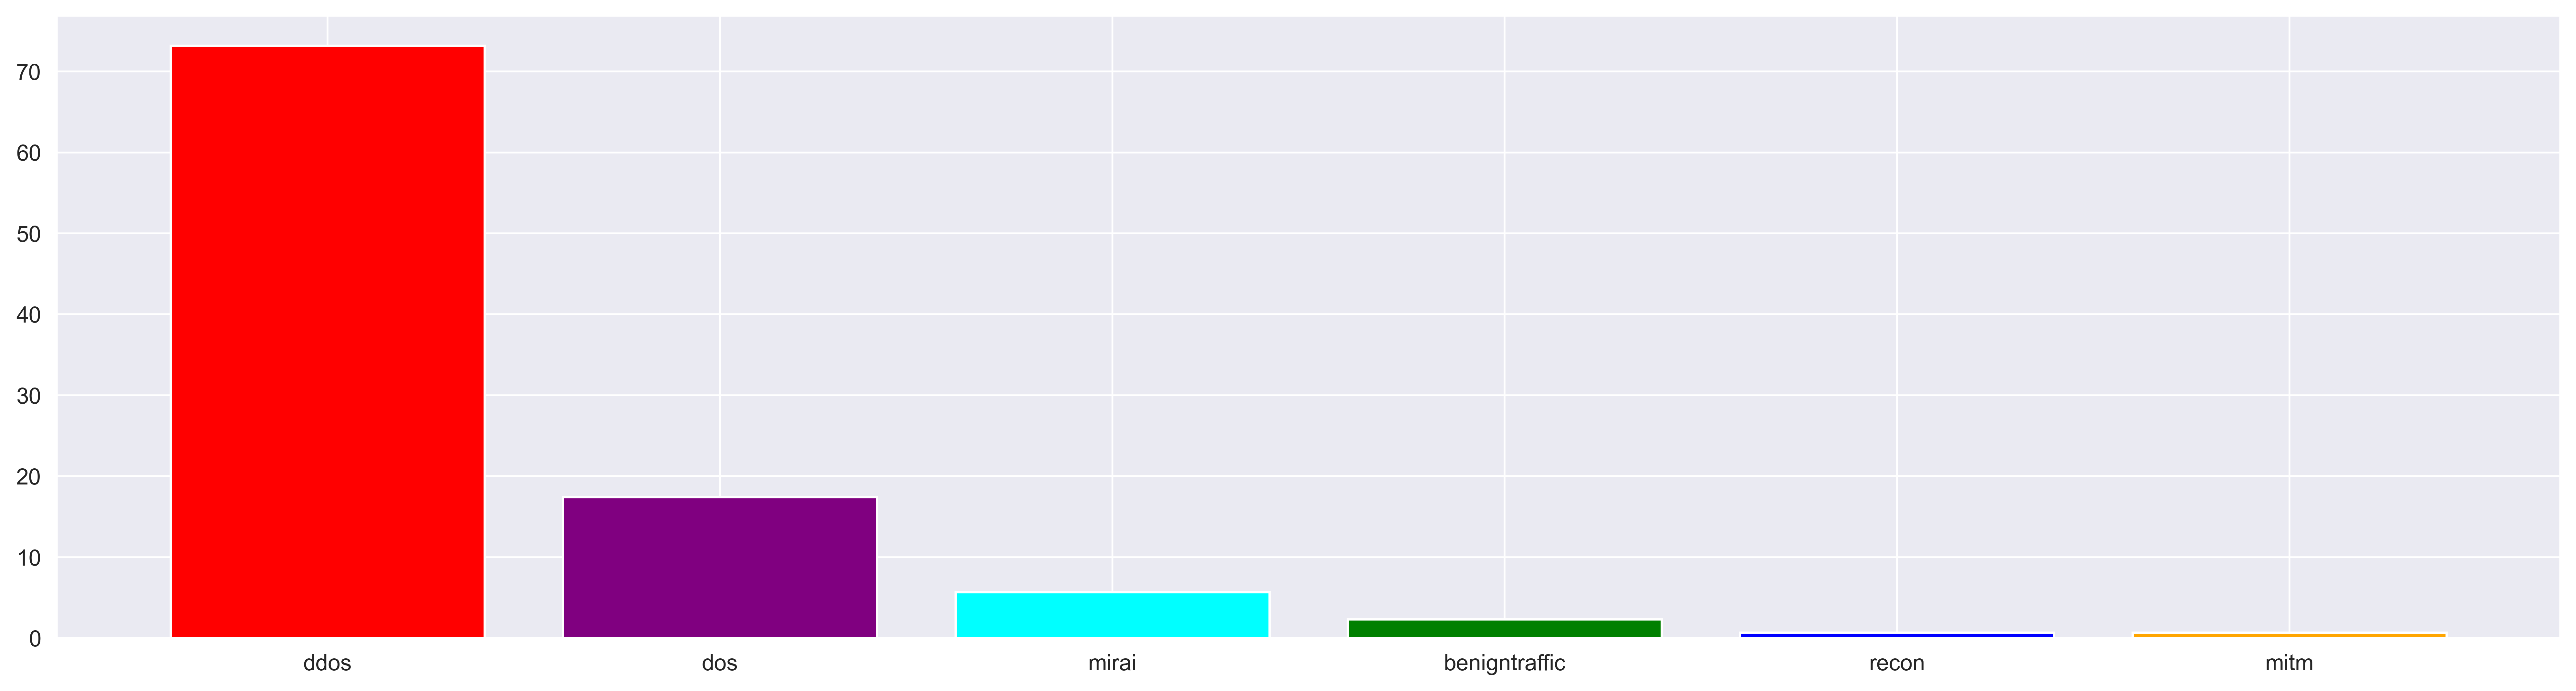

In [7]:
plt.figure(figsize=(20, 5), dpi=500)
plt.bar(
    quick_overview["label"], 
    height=quick_overview["percentage"] , 
    color= quick_overview["label"].replace({
        "ddos": "red",
        "recon": "blue",
        "benigntraffic": "green",
        "mitm": "orange",
        "dos": "purple",
        "mirai": "cyan"
    })
)

In [8]:
profile = ProfileReport(df, title="Profiling Report", explorative=True, lazy= True, minimal = True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:01<00:00, 11.41it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Outliers

In [9]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data=features.to_numpy(),
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="--"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    # gap=1.5
)

plt.show()

MemoryError: Unable to allocate 150. MiB for an array with shape (19710243,) and data type float64

MemoryError: bad allocation

<Figure size 10000x2500 with 1 Axes>

In [10]:
df[[col for i, col in enumerate(df.columns) if i in [1, 3, 4, 9]]].describe().round(1)

,header_size,overall_rate,src_rate,max_value
count,938583.0,938583.0,938583.0,938583.0
mean,101813.4,9163.5,9163.5,177.2
std,1801376.9,100180.6,100180.6,515.4
min,0.0,0.0,0.0,42.0
25%,54.0,2.1,2.1,50.0
50%,54.0,15.7,15.7,54.0
75%,364.0,117.8,117.8,55.1
max,331117370.0,7340032.0,7340032.0,30329.2


# Feature Selection

In [126]:
from sklearn.feature_selection import f_classif , SelectKBest

# feature selection
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(features, target)

selected_indices = list(selector.get_support(indices=True))
selected_features = list(df.columns[selected_indices])

print(f"- {len(selected_indices)} features selected")
print(f"- Selected features indices: {selected_indices}")
print(f"- Selected features: {selected_features}")

- 10 features selected
- Selected features indices: [7, 8, 9, 10, 11, 15, 17, 18, 19, 20]
- Selected features: ['urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'ack_flags', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']


In [12]:
# not as we did in phase 1, we will be testing undersampling and oversampling,
# validated my idea by generative pre-trained transformers

"""You're dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.

Here's a breakdown of your idea, and some suggestions:

---

### ✅ Your Plan (Under + Over Sampling):
Using **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here's how it might work:

#### Step-by-step version of your plan:
1. **Undersample "ddos"** to reduce its impact.
2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.
3. **Possibly leave "dos" as is**, or slightly adjust it.

---

### 🧠 Tips on Executing It:

#### 1. ⚖️ **Target Balance Strategy**
Decide your final desired sample size per class. Example ideas:
- Match to the size of "mirai" (~50K)
- Or go a bit lower to reduce training size, say ~30K per class
- Avoid exact balance — slight randomness can help generalization

#### 2. 🧹 **Undersampling "ddos"**
You can randomly select ~30K–50K rows from "ddos" (from 687K). Make sure to **shuffle** before picking.

#### 3. 🔁 **Oversampling Minorities**
Use techniques like:
- **Random Oversampling** (e.g., simple duplication)
- **SMOTE/ADASYN** (synthetic data generation, if the features support it — i.e., numeric and continuous)

> Note: SMOTE doesn’t work well with categorical data unless encoded carefully.

#### 4. 🧪 **Be Careful with Oversampling**
If you're evaluating on the same dataset, make sure not to **leak duplicated synthetic samples into your validation set** — only oversample in the training split.

---

### ⚖️ Alternative: Use Class Weights
If you're using tree-based models (like XGBoost, LightGBM) or neural nets, consider using **class weighting** instead. It avoids changing the actual data and simply adjusts the cost of misclassification.

---

### 👀 Example Target Distribution
| Label          | Target Count |
|----------------|--------------|
| ddos           | 30,000       |
| benigntraffic  | 30,000       |
| mitm           | 30,000       |
| mirai          | 30,000       |
| recon          | 30,000       |
| dos            | 30,000       |

You could tune this depending on whether you want full balance or slight realism.

---

### 📦 TL;DR
- Your under+over strategy is solid.
- Make sure not to leak synthetic samples into validation/test.
- Consider class weights as a simpler alternative if supported.
- Don’t overdo oversampling — can lead to overfitting if minority class is too tiny.

Would you like help with writing some code to implement this in Python (e.g., using `pandas`, `sklearn`, `imbalanced-learn`)?"""

'You\'re dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.\n\nHere\'s a breakdown of your idea, and some suggestions:\n\n---\n\n### ✅ Your Plan (Under + Over Sampling):\nUsing **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here\'s how it might work:\n\n#### Step-by-step version of your plan:\n1. **Undersample "ddos"** to reduce its impact.\n2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.\n3. **Possibly leave "dos" as is**, or slightly adjust it.\n\n---\n\n### 🧠 Tips on Executing It:\n\n#### 1. ⚖️ **Target Balance Strategy**\nDecide your final desired sample size per class. Example ideas:\n- Match to the size of "mirai" (~50K)\n- Or go a bit lower to reduce training size, say ~30K per class\n- Avoid exact bala

# Dimensionality Reduction

## PCA

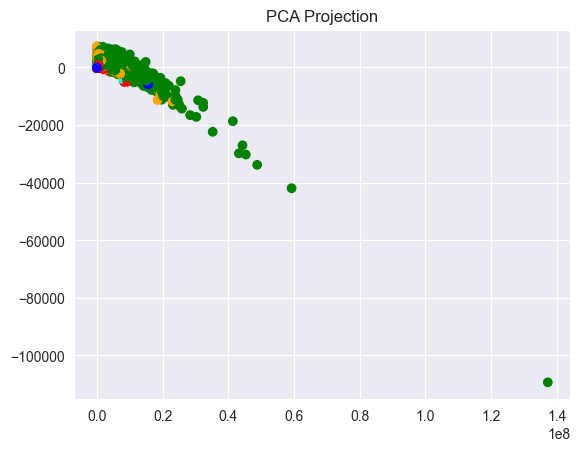

In [127]:
from sklearn.decomposition import PCA

colors_map = {
    "ddos": "red",
    "recon": "blue",
    "benigntraffic": "green",
    "mitm": "orange",
    "dos": "purple",
    "mirai": "cyan"
}

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[selected_features])

plt.scatter(x=pca_result[:, 0], y=pca_result[:, 1], c=target.replace(colors_map))
plt.title("PCA Projection")
plt.show()

In [129]:
from umap import UMAP

def visualize_data(X, y, method='pca') -> None:
    y = pd.Series(y)
    X = pd.DataFrame(X)
    colors_map = {
        "ddos": "red",
        "recon": "blue",
        "benigntraffic": "green",
        "mitm": "orange",
        "dos": "purple",
        "mirai": "cyan"
    }

    result = None
    title = None
    if method == 'pca':
        pca = PCA(n_components=2)
        result = pca.fit_transform(X)
        title = "PCA Projection"


    elif method == 'tsne':
        tsne = TSNE(
            n_components=2,
            perplexity=15,
            learning_rate=10,
            n_jobs=-1  # Use all available cores
        )
        result = tsne.fit(df[selected_features].to_numpy())
        title = "t-SNE Projection"

    elif method == 'umap':
        umap = UMAP(n_components=2, n_jobs=-1)
        result = umap.fit_transform(df[selected_features])
        title = "UMAP Projection"

    plt.scatter(x=result[:, 0], y=result[:, 1], c=y.replace(colors_map))
    plt.title(title)
    plt.show()

## UMAP

In [16]:
# from umap import UMAP
# umap = UMAP(n_components=2, n_jobs=-1)
# umap_data = umap.fit_transform(df[selected_features])
#
# plt.scatter(x=umap_data[:, 0], y=umap_data[:, 1], c=target.replace(colors_map))
# plt.title("PCA Projection")
# plt.show()

## t-SNE

In [17]:
# from openTSNE import TSNE
#
# tsne = TSNE(
#     n_components=2,
#     perplexity=15,
#     learning_rate=10,
#     n_jobs=-1  # Use all available cores
# )
#
# tsne_data = tsne.fit(df[selected_features].to_numpy())

In [18]:
# plt.scatter(x=tsne_data[:, 0], y=tsne_data[:, 1], c=target.replace(colors_map))
# plt.title("t-SNE Projection")
# plt.show()

# Classes Balancing

In [157]:
X = df[selected_features].to_numpy()
y = df["label"]
balance_point = 50_000

In [158]:
describe_column(target)

,label,count,percentage,percentage_str
0,ddos,687027,73.198321,73.20%
1,dos,163428,17.412205,17.41%
2,mirai,53395,5.688895,5.69%
3,benigntraffic,21987,2.342574,2.34%
4,recon,6433,0.685395,0.69%
5,mitm,6313,0.672610,0.67%


In [ ]:
from imblearn.over_sampling import SMOTEN as over_sampler
from imblearn.under_sampling import ClusterCentroids as under_sampler

to_under_sample = []
to_over_sample = []

for cls, count in target.value_counts().items():
    if count < balance_point:
        to_over_sample.append(cls)
    else:
        to_under_sample.append(cls)

rus = under_sampler(
    random_state=0,
    sampling_strategy={cls:balance_point for cls in to_under_sample},

)
X_resampled, y_resampled = rus.fit_resample(X, y)

ros = over_sampler(
    random_state=0,
    sampling_strategy={cls:balance_point for cls in to_over_sample},
)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

In [150]:
describe_column(pd.Series(y_resampled))

,label,count,percentage,percentage_str
0,benigntraffic,10000,16.666667,16.67%
1,ddos,10000,16.666667,16.67%
2,dos,10000,16.666667,16.67%
3,mirai,10000,16.666667,16.67%
4,mitm,10000,16.666667,16.67%
5,recon,10000,16.666667,16.67%


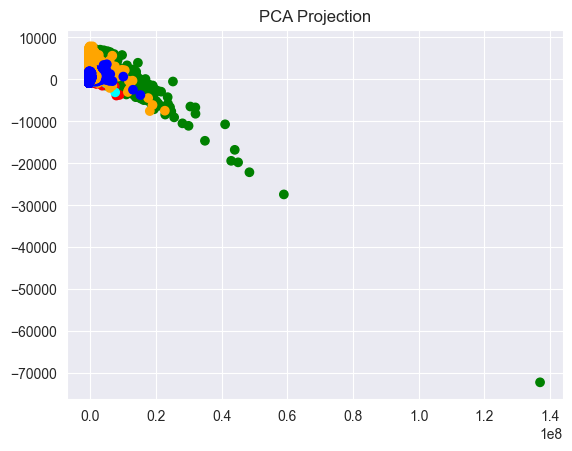

In [151]:
visualize_data(X_resampled, y_resampled)

# Models Training

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [153]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=0,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [154]:
y_pred = rf.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.824944,0.885615,0.834291,0.982045,0.820818,0.848000,0.86475,0.865952,0.866635
recall,0.924152,0.782542,0.895170,0.952128,0.792104,0.838773,0.86475,0.864145,0.864750
f1-score,0.871735,0.830894,0.863659,0.966855,0.806205,0.843362,0.86475,0.863785,0.864442
support,2004.000000,1959.000000,1946.000000,2068.000000,2001.000000,2022.000000,0.86475,12000.000000,12000.000000


In [155]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(random_state=0, max_iter=3000)
nn.fit(X_train, y_train)

MLPClassifier(max_iter=3000, random_state=0)

In [156]:
y_pred = nn.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.757344,0.880347,0.712369,0.968473,0.781229,0.759372,0.804,0.809856,0.810840
recall,0.939122,0.724860,0.873073,0.950677,0.590705,0.741345,0.804,0.803297,0.804000
f1-score,0.838494,0.795073,0.784576,0.959492,0.672738,0.750250,0.804,0.800104,0.801005
support,2004.000000,1959.000000,1946.000000,2068.000000,2001.000000,2022.000000,0.804,12000.000000,12000.000000


In [30]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0, n_jobs=-1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [31]:
y_pred = xgb.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.762348,0.988702,0.658192,0.998518,0.884418,0.789650,0.817233,0.846971,0.846887
recall,0.816336,0.488131,0.982991,0.992954,0.797491,0.825162,0.817233,0.817178,0.817233
f1-score,0.788419,0.653583,0.788452,0.995728,0.838708,0.807016,0.817233,0.811984,0.811982
support,40046.000000,39979.000000,39980.000000,40021.000000,39771.000000,40203.000000,0.817233,240000.000000,240000.000000


In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, max_iter=3000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=0)

In [33]:
y_pred = lr.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.575208,0.821211,0.543757,0.877385,0.674946,0.552351,0.652983,0.674143,0.674036
recall,0.639614,0.451862,0.971486,0.991779,0.433180,0.429744,0.652983,0.652944,0.652983
f1-score,0.605704,0.582958,0.697251,0.931081,0.527689,0.483394,0.652983,0.638013,0.638007
support,40046.000000,39979.000000,39980.000000,40021.000000,39771.000000,40203.000000,0.652983,240000.000000,240000.000000


In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)

In [35]:
y_pred = knn.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

In [36]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ("rf", rf),
    ("nn", nn),
    ("xgb", xgb),
    ("lr", lr),
    ("knn", knn)
]

stacking = StackingClassifier(
    n_jobs=-1,
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_jobs=-1)
)

stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=0)),
                               ('nn',
                                MLPClassifier(hidden_layer_sizes=(4, 8, 4),
                                              max_iter=3000, random_state=0)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categor...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=-1,
                                              num_parallel_tree=None, ...)),
                               ('lr',
                                LogisticRegression(max_iter=3000,
                                                   random_state=0))],
                   final_estimator=RandomForestClassifier(n_jobs=-1),
                   n_jobs=-1)

In [37]:
y_pred = stacking.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,0.998653,0.909896,0.666022,0.999625,0.999950,0.999776,0.911871,0.928987,0.929022
recall,0.999825,0.524375,0.947474,0.999675,0.999925,0.999677,0.911871,0.911825,0.911871
f1-score,0.999239,0.665323,0.782200,0.999650,0.999937,0.999726,0.911871,0.907679,0.907726
support,40046.000000,39979.000000,39980.000000,40021.000000,39771.000000,40203.000000,0.911871,240000.000000,240000.000000


# Submission

In [81]:
testing_data = pd.read_csv(os.path.join(current_path, "data", "original", "phase2", "test.csv"))
id = testing_data['Id']
testing_data = testing_data[selected_features]
testing_data = scaler.fit_transform(testing_data)
testing_data

array([[-0.08331158, -0.11535645, -0.23856674, ...,  0.86072295,
        -0.51917988, -0.44201367],
       [-0.08331158, -0.11535645, -0.23856674, ...,  0.86072295,
        -0.51917988, -0.44201367],
       [-0.0700753 , -0.11228823, -0.23856674, ...,  0.86072295,
        -0.51917988, -0.44201367],
       ...,
       [-0.08331158, -0.11535645, -0.23856674, ...,  0.86072295,
        -0.51917988, -0.44201367],
       [-0.08331158, -0.11535645, -0.26193742, ..., -1.16181404,
        -0.51917988,  2.26237349],
       [-0.08331158, -0.11535645, -0.23895625, ..., -1.16181404,
         1.92611469, -0.44201367]])

In [79]:
y_pred = stacking.predict(testing_data)

In [97]:
result = pd.DataFrame(label_encoder.inverse_transform(y_pred), columns=['Target'])
result['Id'] = id
result = result[['Id', 'Target']]

correct_names = ['DDoS', 'Recon', 'BenignTraffic', 'Mitm', 'DoS', 'Mirai']
result['Target'] = result['Target'].map({name.lower():name for name in correct_names})

result.to_csv(os.path.join(current_path, "data", "original", "phase2", "submission.csv"), index=False)

In [95]:
# !kaggle competitions submit -c csai-253-project-phase-2 -f submission.csv -m "Message"

Target
DoS              71230
BenignTraffic    31512
DDoS              1498
Mitm                29
Mirai               18
Name: count, dtype: int64